In [2]:
'''
Goal in this code block: determine if all of these imports are necessary
'''

import clmm
from clmm import Cosmology
import numpy as np
import math
import matplotlib.pyplot as plt

import sys  #
import h5py #
import matplotlib.pyplot as plt  #
import numpy as np  #T
import random  #
import pandas  #
from scipy import integrate, signal   #T
from scipy.stats import binned_statistic  #T
from scipy.stats import norm   #T
from scipy.special import erf   #T
import astropy   
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)

# **CLMM Triaxiality Module - Mass Fitting Tutorial**

Some write up about the layout of the notebook and how all this works. 

## **Section 1**: Mock Catalog Information
Smushing of NFW generated shears

Mention that the halos are always aligned with the major axis, so arbitrary rotation is not necessary. 

Do some mock catalog information generation. 

q value closer to 1 is more spherical, smaller --> more triaxial

## **Section 2**: Estimators
**Background.** The main goal of this is to get the impact of triaxiality on the mass estimation (aka the excess surface density, $\Delta\Sigma$. To make the estimators of this value based on the mock catalogs, the impact of triaxiality is given via a multipole expansion. The monopole term is our spherical NFW halo, and the quadrupole term gives our triaxiality corrections. If you want to read more on this expansion, see (Tae's paper). 

**Implementation.** To make these estimators, a cosmology must first be defined with CLMM Cosmology, as the argument ```cosmo```. This can then be used to call ```cosmo.eval_sigma_crit``` to get $\Sigma_c$ as it is cosmology dependent. 

With the ```make_estimators``` function, you can directly get the $\Delta\Sigma^{mono}$, $\Delta\Sigma^{quad}_{const}$, and $\Delta\Sigma^{quad}_{4\theta}$ by giving the shear and position arguments from the mock halo and return it in radial bins, taking advantage of scipy's ```binned_statistic``` function.

In [3]:
def log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params):
    
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_mono
    
    #model:
    ds_model = compute_delta_sigma_excess(ell, r_mono, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c

    # Gaussian likelihood:
    #sigma = np.full(len(r_mono), ds_model*0.01) 
    sigma = ds_mono_err
    term1 = -0.5*np.sum(np.log(2*np.pi*(sigma**2)))
    chi2 = ((ds_data - ds_model)**2 / (sigma)**2)
    term2 = -0.5*np.sum(chi2)


    return term1+term2

def log_likelihood_quadrupole_4theta(ds_quad_4theta,ds_quad_4theta_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_4theta
    
    #model:
    ds_model = compute_delta_sigma_4theta(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_4theta_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params):
    sigma_c = 3.77988e+15
    z_cl=0.47
    z_gal=0.8
    mdelta,cdelta,ell = params  # km/s
    
    ds_data = ds_quad_const
    
    #model:
    ds_model = compute_delta_sigma_const(ell, r_quad, mdelta, cdelta, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=1000, delta_mdef=200)#/sigma_c
    
    # Gaussian likelihood:
    #sigma = np.full(len(r_quad), ds_model*0.05) 
    sigma = ds_quad_const_err
    term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
    chi2 = ((ds_data - ds_model)**2 / sigma**2)
    term2 = -0.5*np.sum(chi2)

    return term1+term2

def priors(params, limits):
    
    a,b,c = params
    if (a < limits[0][0] or a > limits[0][1]):        #mdelta
        return -np.inf
    elif (b < limits[1][0] or b > limits[1][1]):      #cdelta
        return -np.inf
    elif (c < limits[2][0] or c > limits[2][1]):      #ell
        return -np.inf
    #elif (d < limits[3][0] or d > limits[3][1]):      #theta_e
    #    return -np.inf

    else:
        return 0.0

In [4]:
def Delta_Sigma_const(w, gamma1, Sigma_crit) :
	return w * Sigma_crit * gamma1 / w

def Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_4theta_cross(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) - w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_const_cross(w, gamma2, Sigma_crit) :
	return w*Sigma_crit*gamma2 / w

def weights(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
	## EQUATION 35, 32, 33
	w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
	w1 = np.cos(4*theta)**2 * w
	w2 = np.sin(4*theta)**2 * w
	return w, w1, w2

def make_radial_bins(x, y, Nbins=10) :
	r = np.sqrt(x**2 + y**2)
	#r_bins = np.linspace(np.min(r), np.max(r), Nbins+1)
	rbin_edges = np.logspace(np.log10(0.4), np.log10(2.5), Nbins+1)
	inds = np.digitize(r, rbin_edges, right=True) - 1
	rbin_mean = np.array([np.mean(r[inds==i]) for i in range(Nbins)])
	return r, rbin_edges, rbin_mean, inds

def make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15, method=1):
    sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
    r = np.sqrt((x_arcsec**2 + y_arcsec**2))
    theta = np.arctan2(y_arcsec, x_arcsec)
    #theta = theta - np.pi/2
    r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
    
    w, w1, w2 = weights(sigma_c, theta)
    DS4theta = Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, sigma_c)
    DSconst = Delta_Sigma_const(w, gamma1, sigma_c)
    
    bins=15
    if method == 1 :
        ## METHOD 1 ##
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins)
        N_i = []
        for i in np.arange(bins-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)


        result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
        gamma1_i = result.statistic
        res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
        gamma2_i = res.statistic
        res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
        DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        DS4theta_i = res.statistic
        res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
        DSconst_i = res.statistic
        DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
        #print(bin_edges)
        r_i = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        #print(r_i)
        
        r_min = 0.3 #Normally 0.4
        r_max = 2.5
        bins_mono=15 #Need more bins always since, if r bin is too thick then averaging doesnt work for shear
        bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins_mono)
        #print(bin_edges)
        N_i = []
        for i in np.arange(bins_mono-1):
            N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
        N_i=np.array(N_i)
        
        r_mono = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
        res = binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='mean', bins=bin_edges)
        gammat_mono = -2*res.statistic
        ds_mono_err = 2*binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_c
        ds_mono = gammat_mono*sigma_c
        
    elif method == 2 :
        ## METHOD 2 ## -- DEPRECATED AS WE WANT DIFFERENT NUMBER OF BINS FOR MONOPOLE AND QUADRUPOLE

        Nbins = bins-1
        arcsec_to_Mpc = 0.00588784182755241
        r, rbin_edges, r_bins, r_inds = make_radial_bins(x_arcsec*arcsec_to_Mpc, y_arcsec*arcsec_to_Mpc, Nbins)

        ds_mono=[]
        ds_mono_err=[]
        delta_sigmas_4theta = []
        delta_sigmas_const = []
        delta_sigmas_4theta_cross = []
        delta_sigmas_const_cross = []
        delta_sigmas_4theta_err = []
        delta_sigmas_const_err = []
        delta_sigmas_4theta_cross_err = []
        delta_sigmas_const_cross_err = []
        for i in range(Nbins):
            select = (r_inds == i)
            theta_i = theta[select]
            gamma1_i = gamma1[select]
            gamma2_i = gamma2[select]
            w_i, w1_i, w2_i = weights(sigma_c, theta_i)
            DS4thetai = Delta_Sigma_4theta(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconsti = Delta_Sigma_const(w_i, gamma1_i, sigma_c)
            DS4thetacrossi = Delta_Sigma_4theta_cross(w1_i, w2_i, gamma1_i, gamma2_i, theta_i, sigma_c)
            DSconstcrossi = Delta_Sigma_const_cross(w_i, gamma2_i, sigma_c)
            DSmonoi = gamma1_i*np.cos(2*theta_i)*sigma_c

            ds_mono.append(-2*np.mean(DSmonoi))
            ds_mono_err.append(2*np.std(DSmonoi)/np.sqrt(len(DSmonoi)))
            delta_sigmas_4theta.append(np.mean(DS4thetai))
            delta_sigmas_4theta_err.append(np.std(DS4thetai)/np.sqrt(len(DS4thetai)))
            delta_sigmas_const.append(np.mean(DSconsti))
            delta_sigmas_const_err.append(np.std(DSconsti)/np.sqrt(len(DSconsti)))
            #delta_sigmas_4theta_cross.append([np.mean(DS4thetacrossi), np.std(DS4thetacrossi)/np.sqrt(len(DS4thetacrossi))])
            #delta_sigmas_const_cross.append([np.mean(DSconstcrossi), np.std(DSconstcrossi)/np.sqrt(len(DSconstcrossi))])

        r_i=np.array(rbin_edges + (rbin_edges[1]-rbin_edges[0]))
        r_mono=r_i
        ds_mono = np.array(ds_mono)
        ds_mono_err = np.array(ds_mono_err)
        DS4theta_i = np.array(delta_sigmas_4theta)
        DS4theta_i_err = np.array(delta_sigmas_4theta_err)
        DSconst_i = np.array(delta_sigmas_const)
        DSconst_i_err = np.array(delta_sigmas_const_err)
        
    # SAFEGUARD AGAINST BINS WITH NANs and 0.0s
    
    ind = np.invert(np.isnan(ds_mono) | np.isnan(ds_mono_err))
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind]
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])     [ind]
    ind = (ds_mono!= 0.0) & (ds_mono_err!= 0.0)
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind] 
    r_mono = r_mono[ind] 
    
    ind = np.invert(np.isnan(DS4theta_i) | np.isnan(DS4theta_i_err) | np.isnan(DSconst_i) | np.isnan(DSconst_i_err))
    DS4theta_i = DS4theta_i[ind]
    DS4theta_i_err = DS4theta_i_err[ind]
    DSconst_i = DSconst_i[ind] 
    DSconst_i_err = DSconst_i_err[ind]
    r_i = np.sqrt(r_i[:-1]*r_i[1:])[ind]
    
    return ds_mono,np.abs(ds_mono_err),r_mono,DS4theta_i,np.abs(DS4theta_i_err),DSconst_i,np.abs(DSconst_i_err),r_i

In [17]:
## implementing it here
dir_loc = "/global/homes/d/dericj/CLMM/examples/triaxiality/Elliptical_lenses_data/catalog_horizontal_rescale_q0.5/"


## formatting the parameters properly
gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

## using make_estimators to calculate delta sigmas (ds)
ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err, ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, 
                                                x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1034654/3148205022.py:1: SyntaxWarning: invalid escape sequence '\D'
  plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, marker='.', ls='None', color='black', label='$\Delta\Sigma^{mono}$')
/tmp/ipykernel_1034654/3148205022.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)


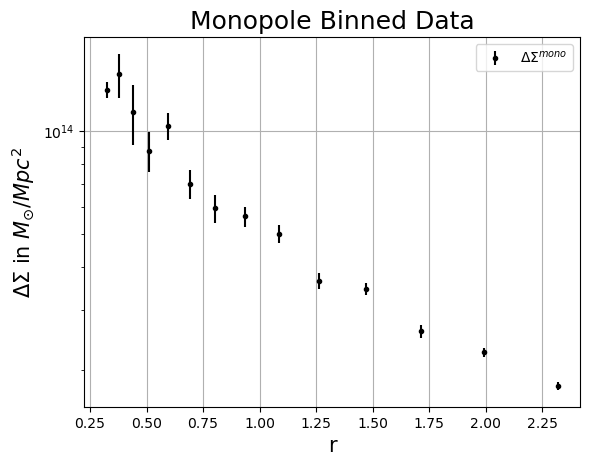

In [23]:
plt.errorbar(r_mono, ds_mono, yerr=ds_mono_err, marker='.', ls='None', color='black', label='$\Delta\Sigma^{mono}$')
plt.xlabel('r', fontsize=15)
plt.title('Monopole Binned Data',fontsize=18)
plt.ylabel('$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

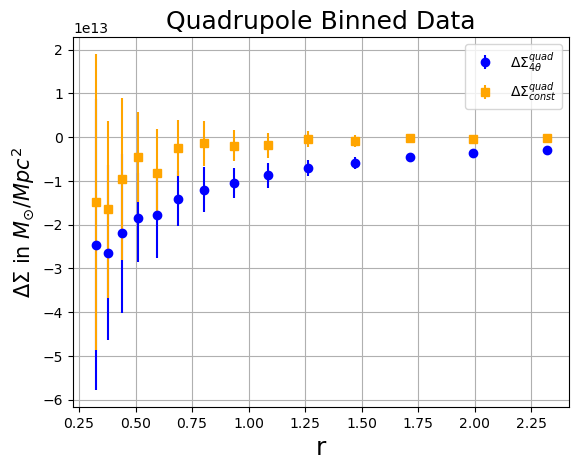

In [71]:
plt.errorbar(r_quad, ds_quad_4theta, yerr=ds_quad_4theta_err, ls='None', marker='o', color='blue', label=r'$\Delta\Sigma^{quad}_{4\theta}$')
plt.errorbar(r_quad, ds_quad_const, yerr=ds_quad_const_err, ls='None', marker='s', color='orange', label=r'$\Delta\Sigma^{quad}_{const}$')

plt.xlabel('r', fontsize=18)
plt.title('Quadrupole Binned Data',fontsize=18)
plt.ylabel(r'$\Delta\Sigma$ in $M_{\odot}/Mpc^2$', fontsize=15)
plt.legend()
plt.grid()
plt.show()

## **Section 3**: MCMC & Fitting
How MCMC and the fitting parameters works in this to get the results we want

**Background.** The goal of this is to get an estimate for the 3 parameters being looked at: $M_{200c}$, $c_{200c}$, and $e$, which is the ellipticity. To do so, the estimated $\Delta\Sigma$ values are used as the prep data for a Markov Chain Monte Carlo (MCMC) walk through the parameter space. Additionally, to the order of which we are approximating, we will be using the true ellipticity is equivalent to $(1-q)/(1+q)$ as opposed to $(1-q^2)/(1+q^2)$ for better statistics. 

**Method.** This process uses the ```emcee``` package to run the MCMC on ```M200c```, ```c200c```, and ```e``` and output the necessary plots. The ```emcee_wrapper``` function will do this all for you with the proper inputsm including priors and posteriors!

In [5]:
from scipy.interpolate import InterpolatedUnivariateSpline
def compute_delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):
    
    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, (r_arr**3)*sigma_0_arr*eta_0_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_1 = (3/(r**4)) * integral_vec(0, r)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0),r)
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    return np.array((ell/4.0)*(2*I_1 - sigma_0*eta_0))

def compute_delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000 ,delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, sigma_0_arr*eta_0_arr/r_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_2 = integral_vec(r, np.inf)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0), r)*r
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return np.array((ell/4.0)*(2*I_2 - sigma_0*eta_0))


def compute_delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):
    r_arr = np.linspace(0.01, 3*np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr  
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    
    
    ## e^2 shenanigans:
    d_eta_0_arr_by_d_r = np.gradient(eta_0_arr,r_arr)*r_arr
    d_eta_0_arr_by_d_r_interpolation_func = InterpolatedUnivariateSpline(r_arr, d_eta_0_arr_by_d_r)
    d_eta_0_by_d_r = d_eta_0_arr_by_d_r_interpolation_func(r)
    
    correction_factor_arr = ((ell)**2*((1/8)*eta_0_arr + (1/16)*d_eta_0_arr_by_d_r + (1/16)*eta_0_arr**2))
    integrand = InterpolatedUnivariateSpline(r_arr, r_arr*sigma_0_arr*correction_factor_arr)
    
    integral_vec = np.vectorize(integrand.integral)
    ##
    
    ### ACTUAL COMPUTATION:
    I = (2/r**2)*integral_vec(0, r)
    
    #q=np.sqrt(2/(1+ell) - 1)
    
    s = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    correction_factor = ((ell)**2*((1/8)*eta_0 + (1/16)*d_eta_0_by_d_r + (1/16)*eta_0**2))
    ds_ell_square_correction = I - s*correction_factor

    
    return clmm.compute_excess_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='critical', alpha_ein=None, 
                                     verbose=False, validate_input=True) + ds_ell_square_correction

In [6]:
def log_posterior(params,gamma1, gamma2, x_arcsec, y_arcsec, sigma_c = 3.77988e+15):
    
    mdelta,cdelta,ell = params    
    
    #rotation:
    #theta_e = theta_e*np.pi/180.0 # in radians
    #gamma1,gamma2,x_arcsec,y_arcsec = halo_rotation(gamma1,gamma2,x_arcsec,y_arcsec,theta_e)
    
    #Prepare the data vector -> estimate delta sigma expansion terms
    global run_estimator
    global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad
    if run_estimator == True:
        run_estimator = False
        ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)
    

    #Evaluate the prior:
    prior=priors(params, limits)
    
    #Avoid likelihood evaluation when prior is -infinity:
    if prior == -np.inf:
        lnP = -np.inf
    else:
        
        lnP = prior + log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) + log_likelihood_quadrupole_const(ds_quad_const,ds_quad_const_err, r_quad,params) + log_likelihood_quadrupole_4theta(ds_quad_4theta, ds_quad_4theta_err, r_quad,params)
        #log_likelihood_monopole(ds_mono,ds_mono_err, r_mono,params) +
    
    # safeguard against NaNs:
    if np.isnan(lnP):
        return -np.inf
    else:
        return lnP

def emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec, z_cl, params_key, limits, true_value,
                 ndim, nwalkers, nsteps=1000, nburn=350, filename=None):  
    
    starting_guess_t=[]
    for i in np.arange(len(params_key)):
        guess=[]
        for j in np.arange(nwalkers):
            guess.append((limits[i][1]-limits[i][0])*np.random.random()+limits[i][0])
        starting_guess_t.append(guess)
    starting_guesses=np.column_stack(starting_guess_t)
    print('Starting guesses for ',nwalkers,' chains:')
    print(starting_guesses)
            
    start=pytime.time()
    
    global run_estimator 
    global ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err,ds_quad_const,ds_quad_const_err,r_quad
    run_estimator = True
    if filename!=None:
        ## STORING THE CHAINS TO FILE
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim) ## Comment this line out to append steps to a previous run stored in the file
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, backend=backend, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
            
    if filename==None:   
        ## RETURNING THE CHAINS WITHOUT STORING TO FILE
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[gamma1, gamma2, x_arcsec, y_arcsec],
                                             vectorize=False, pool=pool)
            pos, prob, state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

    end=pytime.time()
    print("Time taken:{0:.1f} seconds".format(end-start))
            
    post = np.concatenate(sampler.chain[:, nburn: , :])
        
    #Corner plot:

    fig = plt.figure(figsize=[10,10])
    figure = corner.corner(post,labels=params_key, quantiles=[0.16, 0.5, 0.84], 
                           show_titles=True, title_fmt='.2e', fig=fig)
    figure.patch.set_facecolor('white')
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(true_value[xi], color="r")
            ax.axhline(true_value[yi], color="r")
            ax.plot(true_value[xi], true_value[yi], "sr")
            #if yi == 1:
            #    ax.set_xlim([2000,2200])
    
    if f!=None:
        plt.savefig(filename[:-3]+"_corner_plot.png",facecolor="white", dpi="figure", format="png")       
    #Chain plot:

    color=iter(cm.rainbow(np.linspace(0,1,nwalkers)))
    # set up a plot with two windows, one for each parameter:
    plt.figure(figsize=(10,5))
    #plt.patch.set_facecolor('white')
    for i in range(len(params_key)):
        plt.subplot(100*len(params_key)+10+i+1)
        plt.ylabel(params_key[i], fontsize=10)
    for j in range(nwalkers):
        c=next(color)
        for i in range(len(params_key)):
            plt.subplot(100*len(params_key)+10+i+1)
            plt.plot(sampler.chain[j,nburn:,i], ',', color=c)
            
    if f!= None:
        plt.savefig(filename[:-3]+"_chain_plot.png",facecolor="white", dpi="figure", format="png")
    #A_fit = np.quantile((post[:,0].flatten()), 0.5)
    #A_std_fit = np.std(post[:,0].flatten())
    #A.append(A_fit)
    #A_err.append(A_std_fit)
    #print(A)
    #return np.array(A), np.array(A_err), z_final
    mean=[]
    err_minus=[]
    err_plus=[]
    for i in range(len(params_key)):
        mean.append(np.quantile((post[:,i].flatten()), 0.5))
        err_minus.append(np.quantile((post[:,i].flatten()), 0.16))
        err_plus.append(np.quantile((post[:,i].flatten()), 0.84))
    mean = np.array(mean)
    err_plus = np.array(err_plus) - mean
    err_minus = mean - np.array(err_minus)

    return post, mean, err_plus, err_minus

In [94]:
#filename for mcmc
f=dir_loc + "MCMC"

## MCMC parameters:
params_key=["M200c","c200c","e"] #the 3 MCMC parameters
ndim = len(params_key)
nwalkers = ndim*2+4 #establishing the number of MCMC walkers
nsteps = 10000
nburns = 4000 #burn first 4000 steps
np.random.seed(0)

#estabish physical limits on MCMC limits for steps
limits=[[1.0E12,5.0E14],  # mdelta
       [0.0,20.0],     # cdelta
       [0.0001,0.99]]   # e

## setting redshifts
z_cl=0.47
z_gal=0.8

## truth values
q_true = 0.5 #from file
ell_true= 1*(1-q_true**2)/(1+q_true**2)
theta_e_true = 0.0
true_value=[2.0E14, 3.89055, ell_true]

Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [06:27<00:00, 25.82it/s]


Time taken:392.6 seconds


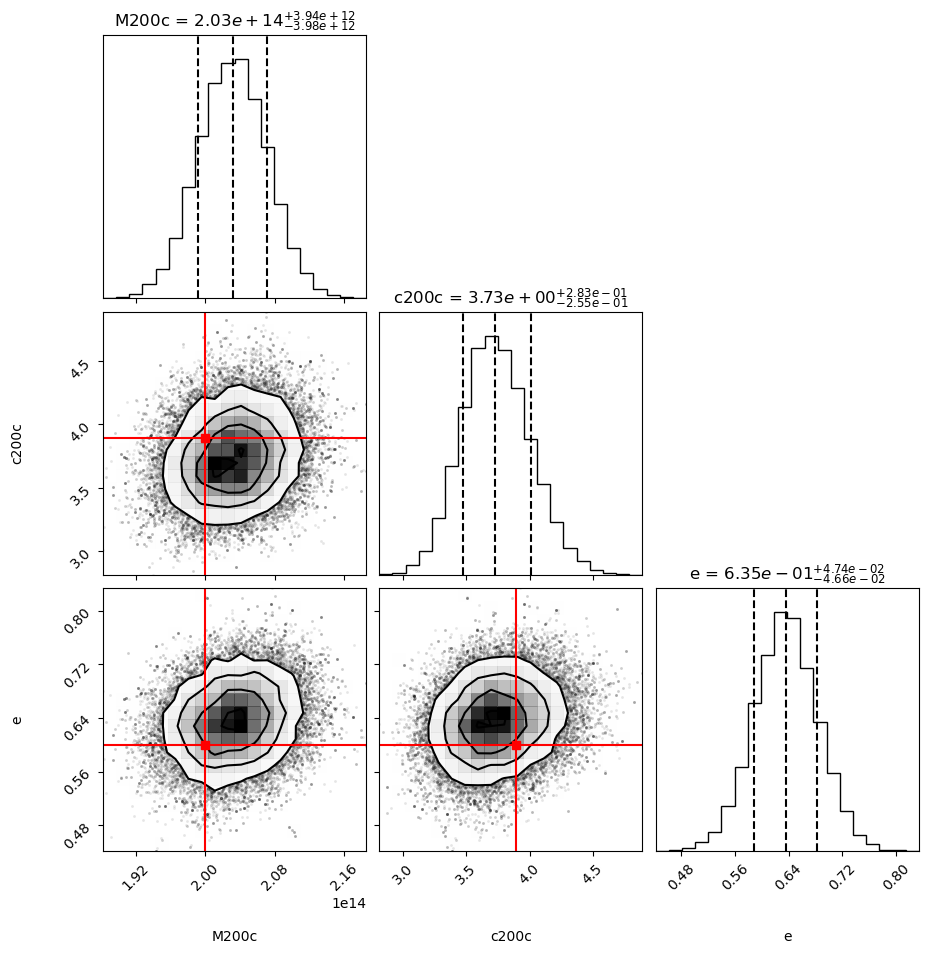

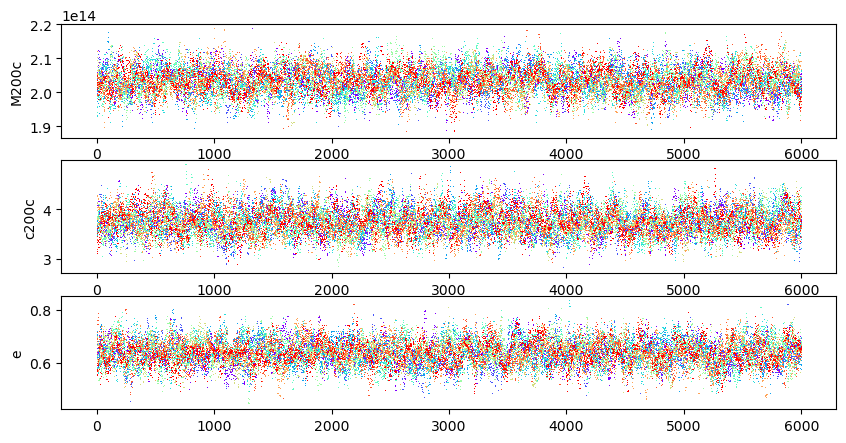

In [95]:
## running emcee
post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=z_cl,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)

Now, with the MCMC statistics, we can do a fit to the model for the monopole and quadrupole terms in their radial bins.

This makes use of the various ```compute_delta_sigma``` functions for the monopole (```excess```) and quadrupole (```const``` and ```4theta```) terms. From the calculated ```mean``` array from MCMC, the means used for the fit is used. 

In [96]:
## extracting the mean values for the fit
mdelta_fit = mean[0]#2E14#
cdelta_fit = mean[1]#3.89#
ell_fit = mean[2]#ell_true

In [97]:
## computing the models
ds_model_mono = compute_delta_sigma_excess(ell_fit, r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
ds_model_const = compute_delta_sigma_const(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)
ds_model_4theta = compute_delta_sigma_4theta(ell_fit, r_quad, mdelta_fit, cdelta_fit, z_cl, cosmo=cosmo, hpmd='nfw', 
                                             sample_N=10000, delta_mdef=200)

ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mdelta_fit, cdelta_fit, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

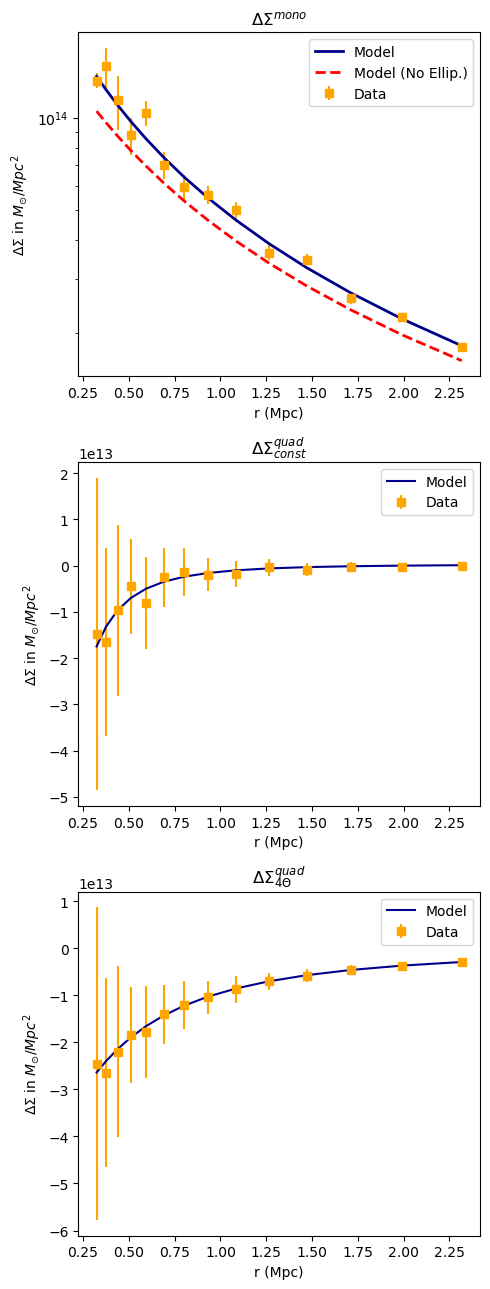

In [98]:
## plotting
plt.figure(figsize=[5,13])
plt.subplot(311)

#mono plots
plt.errorbar(r_mono, ds_mono, yerr=np.abs(ds_mono_err), linestyle='None', marker='s', label='Data', color='orange')
plt.plot(r_mono, ds_model_mono, label='Model', color='darkblue', lw=2)
plt.plot(r_mono, ds_model_without_e_square, label='Model (No Ellip.)', linestyle='--', color='red', lw=2)
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\Delta\Sigma$ in $M_{\odot}/Mpc^2$')
plt.title(r'$\Delta\Sigma^{mono}$')
plt.yscale('log')
plt.legend()

#quad const plots
plt.subplot(312)
plt.errorbar(r_quad, ds_quad_const, linestyle='None', marker='s', yerr=ds_quad_const_err, label='Data', color='orange')
plt.plot(r_quad, ds_model_const, label='Model', color='darkblue')
plt.title(r'$\Delta\Sigma^{quad}_{const}$')
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\Delta\Sigma$ in $M_{\odot}/Mpc^2$')
plt.legend()

#quad 4theta plots
plt.subplot(313)
plt.errorbar(r_quad, ds_quad_4theta, linestyle='None', marker='s', yerr=ds_quad_4theta_err, label='Data', color='orange')
plt.plot(r_quad, ds_model_4theta, label='Model', color='darkblue')
plt.title(r'$\Delta\Sigma^{quad}_{4\Theta}$')
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\Delta\Sigma$ in $M_{\odot}/Mpc^2$')
plt.legend()

plt.tight_layout()


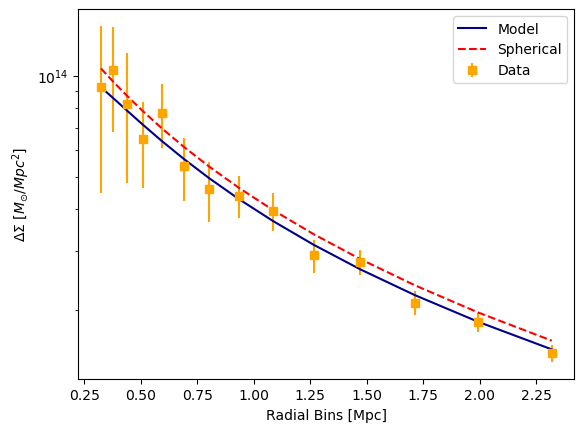

In [99]:
## summation of excess surface densities
sum_data = ds_mono+ds_quad_const+ds_quad_4theta
sum_data_err = np.sqrt(ds_mono_err**2+ds_quad_const_err**2+ds_quad_4theta_err**2)
sum_model = ds_model_mono+ds_model_const+ds_model_4theta

plt.errorbar(r_quad, sum_data, linestyle='None', marker='s', yerr=sum_data_err, color='orange', label='Data')
plt.plot(r_quad, sum_model, color='darkblue', label='Model')
plt.plot(r_quad, ds_model_without_e_square, linestyle='--', color='red', label='Spherical')
plt.xlabel('Radial Bins [Mpc]')
plt.ylabel(r'$\Delta\Sigma$ [$M_{\odot}/Mpc^2$]')
plt.yscale('log')
plt.legend()
plt.show()

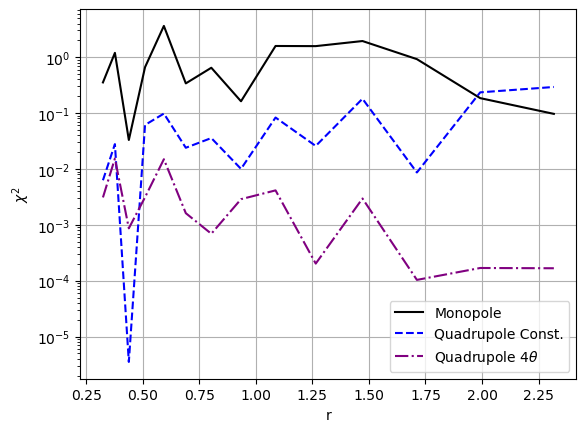

In [100]:
## chi2 analysis
def chi2(data, model, err):
    return ((data - model)**2 / (err)**2)

chi2_mono = chi2(ds_mono, ds_model_mono, ds_mono_err)
chi2_const = chi2(ds_quad_const, ds_model_const, ds_quad_const_err)
chi2_4theta = chi2(ds_quad_4theta, ds_model_4theta, ds_quad_4theta_err)

plt.plot(r_mono, chi2_mono, label='Monopole', color='black')
plt.plot(r_quad, chi2_const, label='Quadrupole Const.', color='blue', linestyle='--')
plt.plot(r_quad, chi2_4theta, label=r'Quadrupole $4 \theta$', color='purple', linestyle='-.')
plt.yscale('log')
plt.xlabel('r')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.grid()
plt.show()

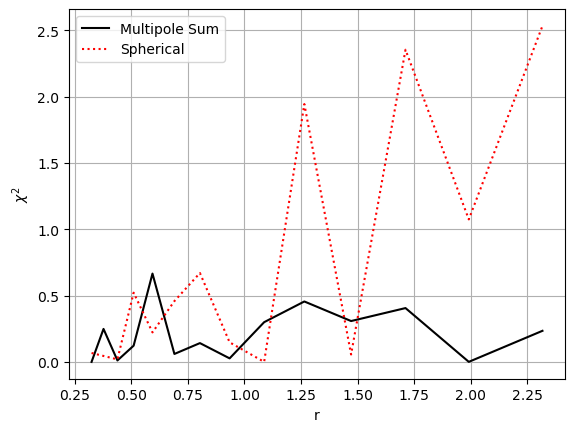

In [101]:
chi2_total = chi2(sum_data, sum_model, sum_data_err)
chi2_sphere = chi2(sum_data, ds_model_without_e_square, sum_data_err)

plt.plot(r_mono, chi2_total, label='Multipole Sum', color='black')
plt.plot(r_mono, chi2_sphere, label='Spherical', color='red', linestyle='dotted')

#plt.yscale('log')
plt.xlabel('r')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.grid()
plt.show()

**Comparing the Package over Different $q$ values**

Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:61: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((ds_data - ds_model)**2 / sigma**2)
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:64: RuntimeWarning: invalid value encountered in scalar add
  return term1+term2
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:61: Runtim

Time taken:240.7 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:04<00:00, 40.82it/s]


Time taken:247.8 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:07<00:00, 40.34it/s]


Time taken:250.8 seconds


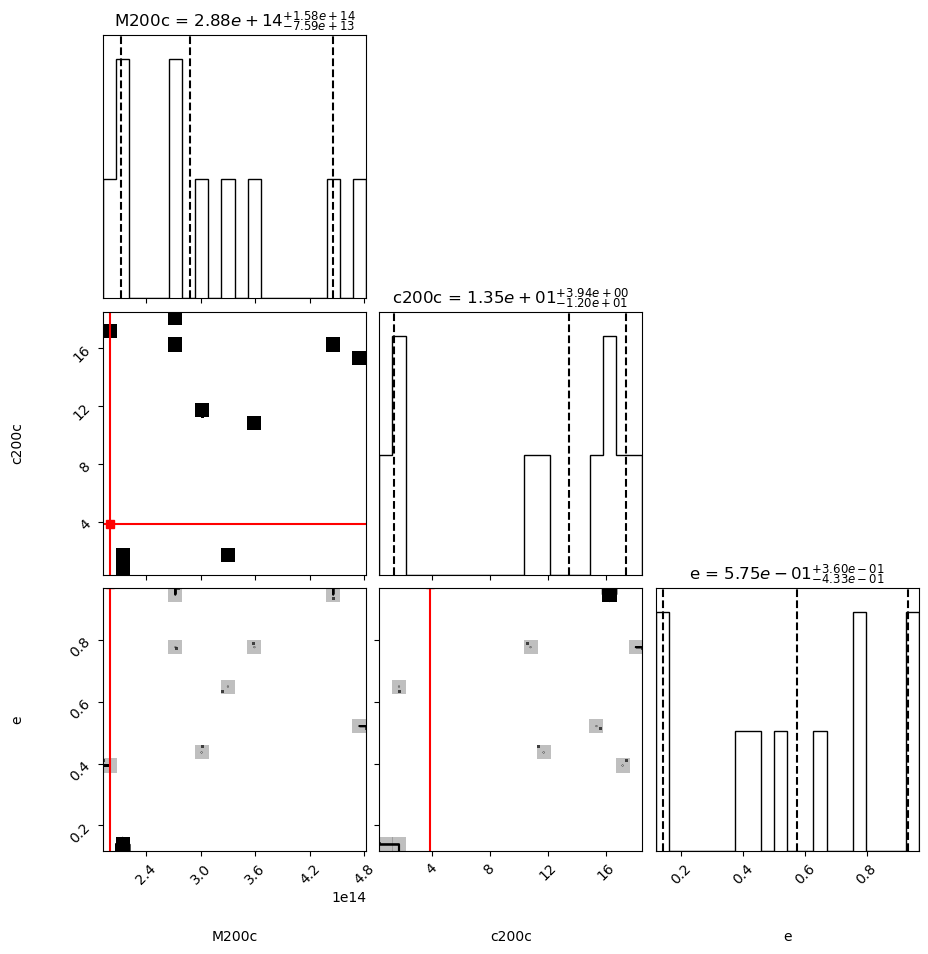

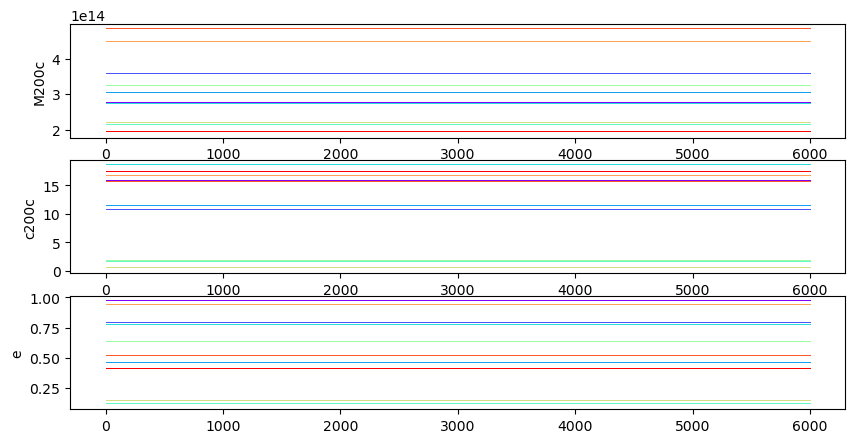

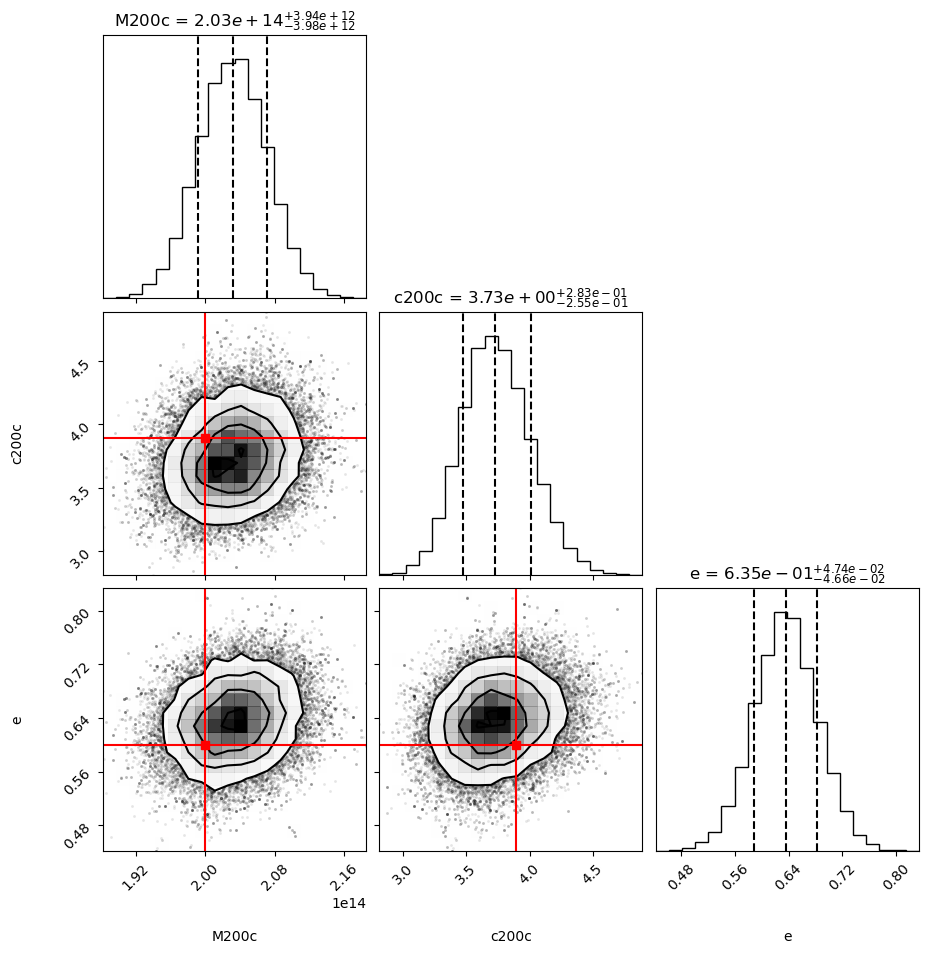

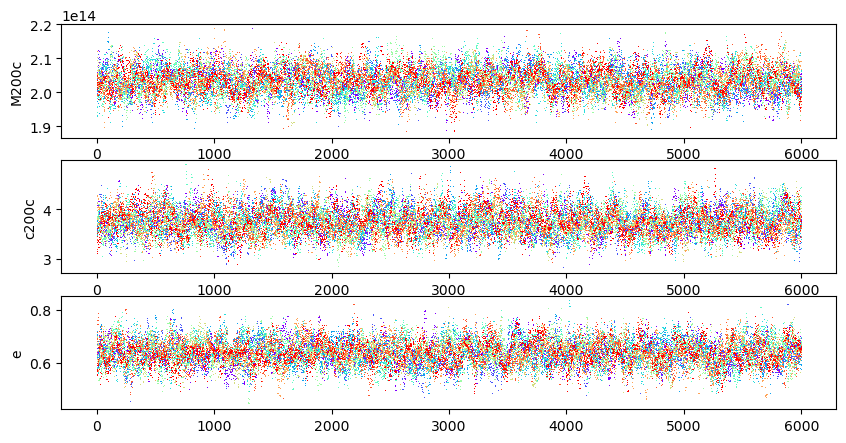

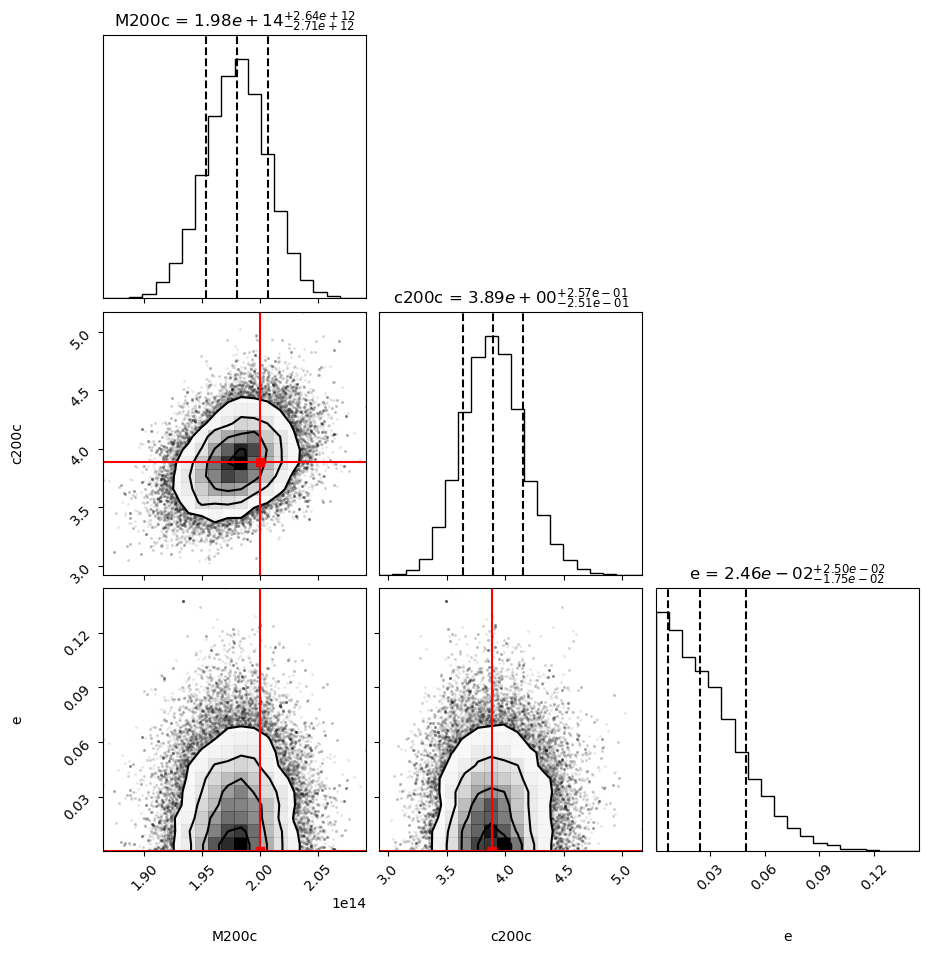

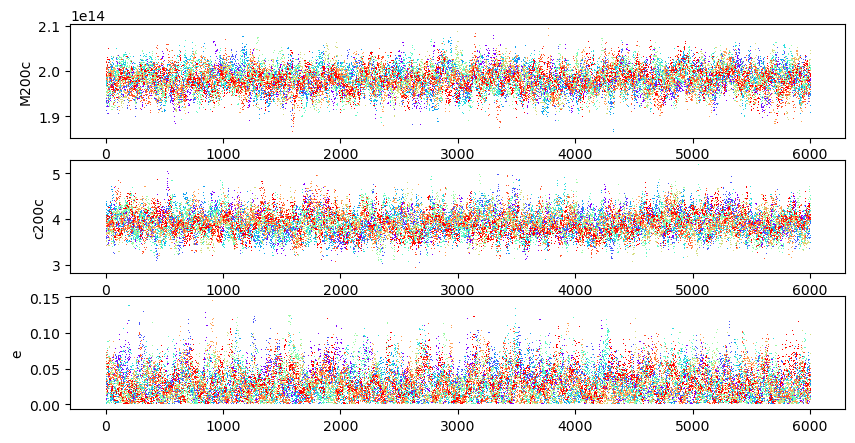

In [10]:
q_vals = np.array([0.1, 0.5, 1.0])

mono_q_vals = []; mono_q_err = []
theta4_q_vals = []; theta4_q_err = []
const_q_vals = []; const_q_err = []
r_monos = []; r_quads = []
m_deltas = []; c_deltas = []; e_deltas = []

mono_models = []; theta_models = []; const_models = []; sph_models = []

for q in q_vals:
    dir_loc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q)+"/"

    ## formatting the parameters properly
    gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
    gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

    x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
    y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

    ## using make_estimators to calculate delta sigmas (ds)
    ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err, ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, 
                                                    x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)
    
    ## appending
    mono_q_vals.append(ds_mono); mono_q_err.append(ds_mono_err)
    theta4_q_vals.append(ds_quad_4theta); theta4_q_err.append(ds_quad_4theta_err)
    const_q_vals.append(ds_quad_const); const_q_err.append(ds_quad_const_err)
    r_monos.append(r_mono); r_quads.append(r_quads)
    
    ## running and saving the MCMC
    #filename for mcmc
    f=dir_loc + "MCMC"

    #MCMC parameters:
    params_key=["M200c","c200c","e"] #the 3 MCMC parameters
    ndim = len(params_key)
    nwalkers = ndim*2+4 #establishing the number of MCMC walkers
    nsteps = 10000
    nburns = 4000 #burn first 4000 steps
    np.random.seed(0)

    #estabish physical limits on MCMC limits for steps
    limits=[[1.0E12,5.0E14],  # mdelta
           [0.0,20.0],     # cdelta
           [0.0001,0.99]]   # e

    #setting redshifts
    z_cl=0.47
    z_gal=0.8

    #truth values
    ell_true= 1*(1-q**2)/(1+q**2)
    theta_e_true = 0.0
    true_value=[2.0E14, 3.89055, ell_true]
    
    #running mcmc
    post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=z_cl,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)
    
    ## computing the models
    ds_model_mono = compute_delta_sigma_excess(mean[2], r_mono, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)
    ds_model_const = compute_delta_sigma_const(mean[2], r_quad, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)
    ds_model_4theta = compute_delta_sigma_4theta(mean[2], r_quad, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)

    ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mean[0], mean[1], z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                         verbose=False, validate_input=True)
    
    mono_models.append(ds_model_mono)
    const_models.append(ds_model_const)
    theta_models.append(ds_model_4theta)
    sph_models.append(ds_model_without_e_square)

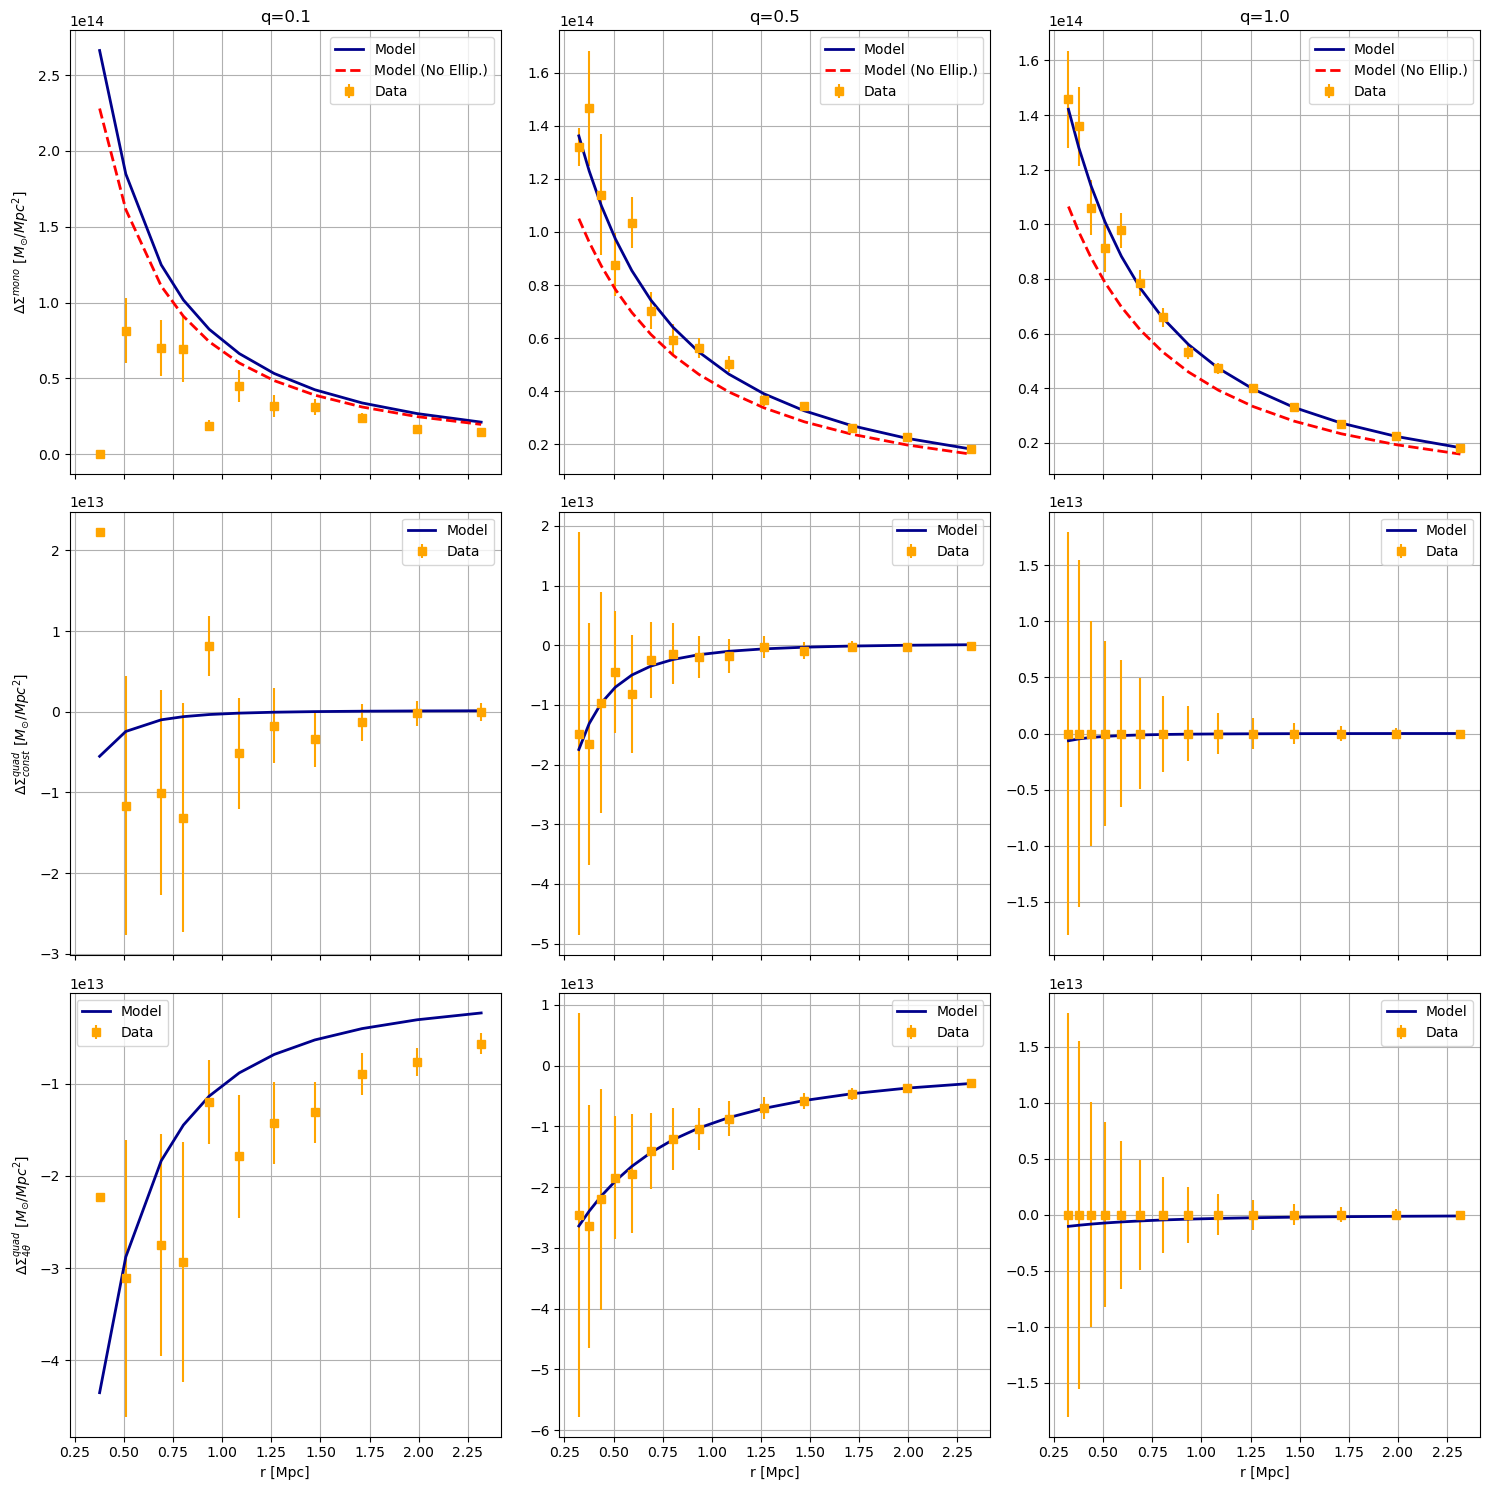

In [44]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(15,15))

for i in range(3):
    ax[0][i].errorbar(r_monos[i], mono_q_vals[i], yerr=np.abs(mono_q_err[i]), linestyle='None', marker='s', label='Data', color='orange')
    ax[0][i].plot(r_monos[i], mono_models[i], label='Model', color='darkblue', lw=2)
    ax[0][i].plot(r_monos[i], sph_models[i], label='Model (No Ellip.)', linestyle='--', color='red', lw=2)
    ax[0][i].set_title("q="+str(q_vals[i]))
    #ax[0][i].set_yscale('log')
    ax[0][i].grid(True)
    ax[0][i].legend()
    
    ax[1][i].errorbar(r_monos[i], const_q_vals[i], yerr=np.abs(const_q_err[i]), linestyle='None', marker='s', label='Data', color='orange')
    ax[1][i].plot(r_monos[i], const_models[i], label='Model', color='darkblue', lw=2)
    #ax[0][i].set_yscale('log')
    ax[1][i].grid(True)
    ax[1][i].legend()
    
    ax[2][i].errorbar(r_monos[i], theta4_q_vals[i], yerr=np.abs(theta4_q_err[i]), linestyle='None', marker='s', label='Data', color='orange')
    ax[2][i].plot(r_monos[i], theta_models[i], label='Model', color='darkblue', lw=2)
    #ax[0][i].set_yscale('log')
    ax[2][i].grid(True)
    ax[2][i].legend()
    
    ax[2][i].set_xlabel('r [Mpc]')
    ax[0][0].set_ylabel(r'$\Delta\Sigma^{mono}$ [$M_{\odot}/Mpc^2$]')
    ax[1][0].set_ylabel(r'$\Delta\Sigma^{quad}_{const}$ [$M_{\odot}/Mpc^2$]')
    ax[2][0].set_ylabel(r'$\Delta\Sigma^{quad}_{4\theta}$ [$M_{\odot}/Mpc^2$]')

plt.tight_layout()

Total $\Delta\Sigma$ from Data for q=0.1: 1.9574835108631406e+14
Total $\Delta\Sigma$ from Triaxial Model for q=0.1: 8.46609860657418e+14
Total $\Delta\Sigma$ from Spherical Model for q=0.1: 8.879354138099439e+14


Total $\Delta\Sigma$ from Data for q=0.5: 7.159153580420184e+14
Total $\Delta\Sigma$ from Triaxial Model for q=0.5: 6.917996876976092e+14
Total $\Delta\Sigma$ from Spherical Model for q=0.5: 7.592041124515858e+14


Total $\Delta\Sigma$ from Data for q=1.0: 9.619649460506689e+14
Total $\Delta\Sigma$ from Triaxial Model for q=1.0: 9.499428799799256e+14
Total $\Delta\Sigma$ from Spherical Model for q=1.0: 7.591117233668304e+14




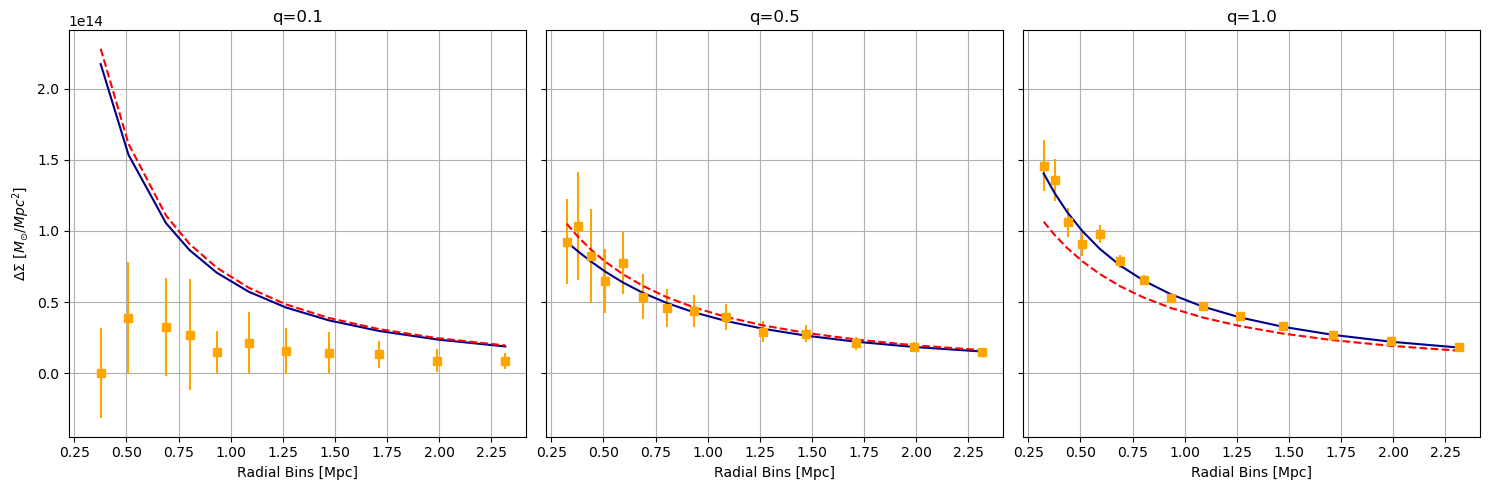

In [61]:
## now to see what that looks like in summed form
summed_data = []
summed_err = []
summed_model = []

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
for i in range(len(r_monos)):
    #summing the models
    summed_data.append(mono_q_vals[i]+const_q_vals[i]+theta4_q_vals[i])
    summed_err.append(np.sqrt(mono_q_err[i]**2+const_q_vals[i]**2+theta4_q_vals[i]**2))
    summed_model.append(mono_models[i]+const_models[i]+theta_models[i])
    
    #plotting the summed info
    ax[i].errorbar(r_monos[i], summed_data[i], linestyle='None', marker='s', yerr=summed_err[i], color='orange', label='Data')
    ax[i].plot(r_monos[i], summed_model[i], color='darkblue', label='Model')
    ax[i].plot(r_monos[i], sph_models[i], linestyle='--', color='red', label='Spherical')
    
    ax[i].set_title("q="+str(q_vals[i]))
    ax[i].set_xlabel('Radial Bins [Mpc]')
    ax[0].set_ylabel(r'$\Delta\Sigma$ [$M_{\odot}/Mpc^2$]')
    ax[i].grid(True)
    #ax[i].set_yscale('log')
    
    #printing total delta_sigma
    print(r"Total $\Delta\Sigma$ from Data for q="+str(q_vals[i])+": "+str(np.format_float_scientific(np.sum(summed_data[i]))))
    print(r"Total $\Delta\Sigma$ from Triaxial Model for q="+str(q_vals[i])+": "+str(np.format_float_scientific(np.sum(summed_model[i]))))
    print(r"Total $\Delta\Sigma$ from Spherical Model for q="+str(q_vals[i])+": "+str(np.format_float_scientific(np.sum(sph_models[i]))))
    print("\n")

plt.tight_layout()

**Testing the Limits of the Approximation**

In [62]:
q_vals = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

mono_q_vals = []; mono_q_err = []
theta4_q_vals = []; theta4_q_err = []
const_q_vals = []; const_q_err = []
r_monos = []; r_quads = []
m_deltas = []; c_deltas = []; e_deltas = []

mono_models = []; theta_models = []; const_models = []; sph_models = []

for q in q_vals:
    dir_loc = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q)+"/"

    ## formatting the parameters properly
    gamma1 = np.load(dir_loc+"gamma1.npy").flatten()
    gamma2 = np.load(dir_loc+"gamma2.npy").flatten()

    x_arcsec = np.load(dir_loc+"x_arcsec.npy").flatten()
    y_arcsec = np.load(dir_loc+"y_arcsec.npy").flatten()

    ## using make_estimators to calculate delta sigmas (ds)
    ds_mono,ds_mono_err,r_mono,ds_quad_4theta,ds_quad_4theta_err, ds_quad_const,ds_quad_const_err,r_quad = make_estimators(gamma1, gamma2, 
                                                    x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)
    
    ## appending
    mono_q_vals.append(ds_mono); mono_q_err.append(ds_mono_err)
    theta4_q_vals.append(ds_quad_4theta); theta4_q_err.append(ds_quad_4theta_err)
    const_q_vals.append(ds_quad_const); const_q_err.append(ds_quad_const_err)
    r_monos.append(r_mono); r_quads.append(r_quads)
    
    ## running and saving the MCMC
    #filename for mcmc
    f=dir_loc + "MCMC"

    #MCMC parameters:
    params_key=["M200c","c200c","e"] #the 3 MCMC parameters
    ndim = len(params_key)
    nwalkers = ndim*2+4 #establishing the number of MCMC walkers
    nsteps = 10000
    nburns = 4000 #burn first 4000 steps
    np.random.seed(0)

    #estabish physical limits on MCMC limits for steps
    limits=[[1.0E12,5.0E14],  # mdelta
           [0.0,20.0],     # cdelta
           [0.0001,0.99]]   # e

    #setting redshifts
    z_cl=0.47
    z_gal=0.8

    #truth values
    ell_true= 1*(1-q**2)/(1+q**2)
    theta_e_true = 0.0
    true_value=[2.0E14, 3.89055, ell_true]
    
    #running mcmc
    post, mean, err_plus, err_minus = emcee_wrapper(gamma1, gamma2, x_arcsec, y_arcsec,z_cl=z_cl,
                                                params_key=params_key,limits=limits,true_value=true_value, ndim=ndim,nwalkers=nwalkers,
                                                nsteps=nsteps, nburn=nburns, filename=f)
    
    ## computing the models
    ds_model_mono = compute_delta_sigma_excess(mean[2], r_mono, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)
    ds_model_const = compute_delta_sigma_const(mean[2], r_quad, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)
    ds_model_4theta = compute_delta_sigma_4theta(mean[2], r_quad, mean[0], mean[1], z_cl, cosmo=cosmo, hpmd='nfw', 
                                                 sample_N=10000, delta_mdef=200)

    ds_model_without_e_square = clmm.compute_excess_surface_density(r_mono, mean[0], mean[1], z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                         verbose=False, validate_input=True)
    
    mono_models.append(ds_model_mono)
    const_models.append(ds_model_const)
    theta_models.append(ds_model_4theta)
    sph_models.append(ds_model_without_e_square)

Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:61: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((ds_data - ds_model)**2 / sigma**2)
/tmp/ipykernel_1055685/3189626756.py:61: RuntimeWarning: divide by zero encountered in divide
  chi2 = ((ds_data - ds_model)**2 / sigma**2)
/tmp/ipykernel_1055685/3189626756.py:60: RuntimeWarning: divide by zero encountered in log
  term1 = -0.5*np.sum(np.log(2*np.pi*sigma**2))
/tmp/ipykernel_1055685/3189626756.py:64: RuntimeWarning: invalid value encountered in scalar add
  return term1+term2
/tmp/ipykernel_1055685/3189626756.py:64: RuntimeWarning: invalid value encountered in scalar add
  return term1+term2
/tmp/ipykernel_1055685/3189626756.py:61: RuntimeWarning: divide by 

Time taken:258.5 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:36<00:00, 36.20it/s]


Time taken:280.0 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:15<00:00, 39.14it/s]


Time taken:258.9 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:12<00:00, 39.60it/s]


Time taken:256.9 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


100%|██████████| 10000/10000 [04:39<00:00, 35.73it/s]


Time taken:284.6 seconds
Starting guesses for  10  chains:
[[2.74857938e+14 1.58345008e+01 9.68834297e-01]
 [3.57879494e+14 1.05778984e+01 7.91187063e-01]
 [3.01778925e+14 1.13608912e+01 4.56918421e-01]
 [2.72896708e+14 1.85119328e+01 7.72745832e-01]
 [2.12403745e+14 1.42072116e+00 1.17179854e-01]
 [3.23301162e+14 1.74258599e+00 6.33557819e-01]
 [2.19356018e+14 4.04367949e-01 1.42005419e-01]
 [4.45994727e+14 1.66523969e+01 9.35227761e-01]
 [4.81867717e+14 1.55631350e+01 5.16677654e-01]
 [1.92337318e+14 1.74002430e+01 4.10573854e-01]]


  9%|▊         | 852/10000 [00:21<03:43, 40.94it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## **Section 6:** Triaxiality as a CLMM Object
Use https://github.com/LSSTDESC/CLMM/blob/9f0dbbc43c0e7d29579b96161faaf6c7a7067948/examples/demo_theory_functionality_oo.ipynb#L264 as a guide to implementing Rance's code in the object form. 

## **Section 7:** Data Ops with Quadrupole Moment
Use https://github.com/LSSTDESC/CLMM/blob/issue/591/triaxiality/examples/demo_mock_ensemble.ipynb to include Tae's Data Ops version of the code for the galaxy cluster data op and the cluster ensemble data op. 